In [358]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import datetime
from pandas import Grouper
from sklearn.metrics import mean_absolute_error
import numpy as np

In [2]:
def calculate_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371*1000  # m
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = earth_radius * c
    return d

In [3]:
def getUnixTime(d,s):
    if d=='S':
        a=datetime.datetime.strptime('Dec 1 2016 '+s, '%b %d %Y %H:%M:%S').timestamp()
        b=datetime.datetime(1970,1,1).timestamp()
        return int(a-b)
    if d=='N':
        a=datetime.datetime.strptime('Dec 1 2016 '+s, '%b %d %Y %I:%M:%S %p').timestamp()
        b=datetime.datetime(1970,1,1).timestamp()
        return int(a-b)

In [63]:
def geneDir(Longitude,Latitude,Last_Lon,Last_Lat,Speed):
    if Speed==0:
        return 'Stop'
    Lon_diff=Longitude-Last_Lon
    Lat_diff=Latitude-Last_Lat
    if abs(Lat_diff)>abs(Lon_diff):
        if Latitude>Last_Lat:
            return 'N'
        else:
            return 'S'
    else:
        if Longitude>Last_Lon:
            return 'E'
        else:
            return 'W'
    return 'Unknown'

In [317]:
def round_to_min(s):
    return s[:7]+'0'+s[8:]

In [279]:
df=pd.read_pickle('gps_20161201_processed')

In [281]:
Lat_max,Long_max,Lat_min,Long_min=34.241, 108.943,34.234, 108.9415
timeZoneDelay=8*60*60

In [503]:
df_section=df[(Long_min<=df.Longitude)&
                        (df.Longitude<=Long_max)&
                        (Lat_min<=df.Latitude)&
                        (df.Latitude<=Lat_max)]
df_section['TimeDiff']=df_section.groupby(['Driver_ID','Order_ID']).Time_Stamp.diff()
df_section['time']=pd.to_datetime(df_section.Time_Stamp+timeZoneDelay, unit='s')
df_section['Last_Lon']=df_section.groupby(['Driver_ID','Order_ID']).Longitude.shift(1)
df_section['Last_Lat']=df_section.groupby(['Driver_ID','Order_ID']).Latitude.shift(1)
df_section=df_section.dropna()
df_section['Dist']=df_section.apply(lambda x: calculate_distance(x.Latitude,x.Longitude,x.Last_Lat,x.Last_Lon),axis=1)
df_section['Speed']=df_section['Dist']/df_section['TimeDiff']*3.6
df_section['Direction']=df_section.apply(lambda x: geneDir(x.Longitude,x.Latitude,x.Last_Lon,x.Last_Lat,x.Speed),axis=1)
columns_drop=['Driver_ID','Order_ID']
df_section=df_section.drop(columns=columns_drop)

In [502]:
Prediction_N=pd.read_csv('./Predictions/Predictions_north.csv')
Prediction_S=pd.read_csv('./Predictions/Predictions_south.csv')
Prediction_N['Direction']='N'
Prediction_S['Direction']='S'
Prediction=pd.concat([Prediction_S,Prediction_N],axis=0)
Prediction['timeStamp']=Prediction.apply(lambda x:getUnixTime(x.Direction,x.time),axis=1)
Prediction['time']=Prediction.apply(lambda x: round_to_min(pd.to_datetime(x['timeStamp'], unit='s').strftime('%r')),axis=1)
Prediction=Prediction.drop(columns='timeStamp').rename(columns={'speed':'Pred_Speed'})

In [496]:
threshold_list=np.linspace(0.965, 0.966, 1001)
MAE_list=[]

In [498]:
for th in threshold_list:
    df_NS=df_section[df_section.Speed<=df_section.Speed.quantile(th)].groupby(['Direction',Grouper(key='time', freq='5min')]).Speed.mean().reset_index()
    df_NS.time=df_NS.time.dt.strftime('%r')
    df_NS=df_NS[df_NS.apply(lambda x: x.Direction in ['N','S'],axis=1)]
    df_tod=pd.DataFrame({'time':pd.date_range(pd.to_datetime(1480550400, unit='s'), 
                                              periods=288, freq='5min').strftime('%r')})
    df_tod_dir=pd.concat([pd.concat([df_tod,pd.DataFrame({'Direction':['N']*288})],axis=1),
                          pd.concat([df_tod,pd.DataFrame({'Direction':['S']*288})],axis=1)],axis=0)
    df_NS_full=df_tod_dir.merge(df_NS,on=['time','Direction'],how='left')
    df_speed=df_NS_full.merge(Prediction,on=['time','Direction'],how='left').fillna('x')
    y_pred_S=df_speed[df_speed.Direction=='S'].Pred_Speed.tolist()
    y1_S=np.array([np.nan if i=='x' else float(i) for i in y_pred_S])
    y_S=df_speed[df_speed.Direction=='S'].Speed.tolist()
    y2_S=np.array([np.nan if i=='x' else float(i) for i in y_S])
    y_pred_N=df_speed[df_speed.Direction=='N'].Pred_Speed.tolist()
    y1_N=np.array([np.nan if i=='x' else float(i) for i in y_pred_N])
    y_N=df_speed[df_speed.Direction=='N'].Speed.tolist()
    y2_N=np.array([np.nan if i=='x' else float(i) for i in y_N])
    y_pred=np.concatenate((y1_S,y1_N),axis=0)
    y=np.concatenate((y2_S,y2_N),axis=0)
    MAE_list.append(mean_absolute_error(y_pred[(~np.isnan(y_pred))&(~np.isnan(y))],y[(~np.isnan(y_pred))&(~np.isnan(y))]))
    print(th,end='\r')

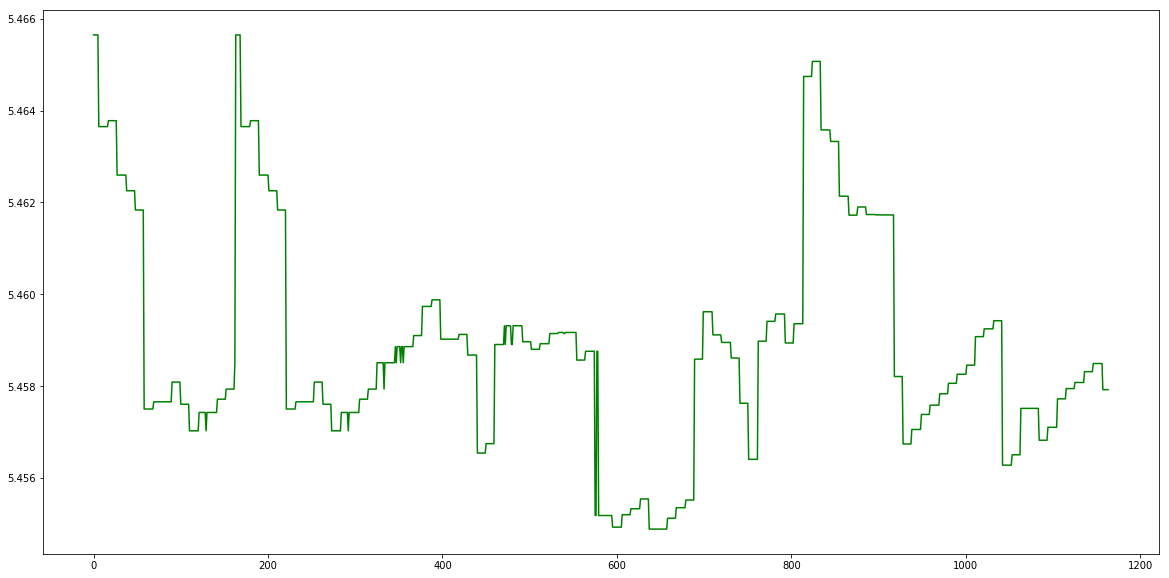

In [499]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(range(len(MAE_list)),MAE_list,'g-')
plt.show()

In [500]:
threshold_list[MAE_list.index(min(MAE_list))]

0.965637

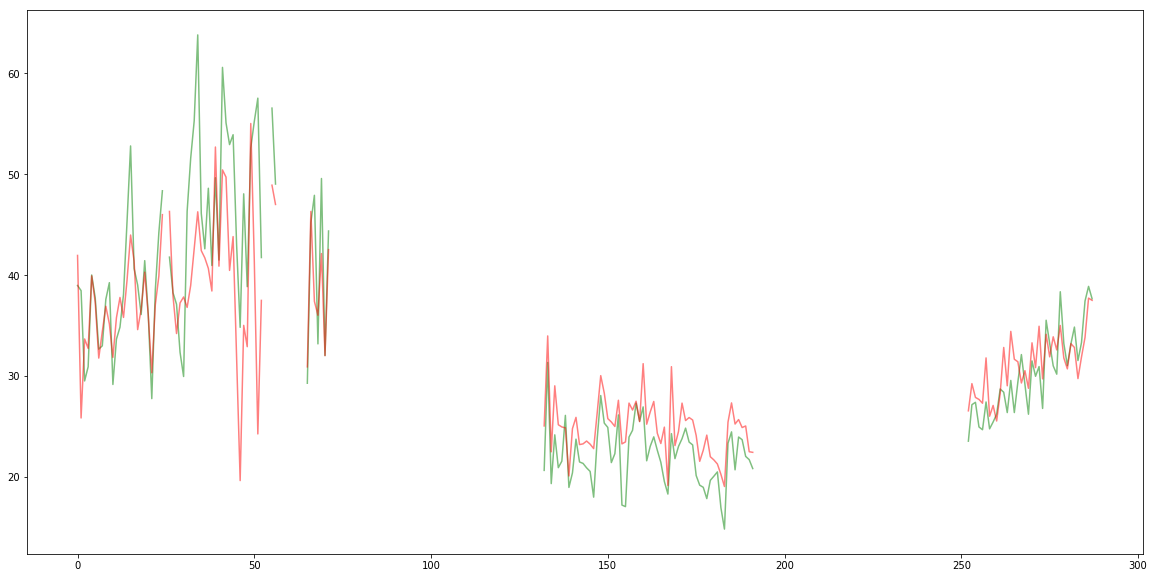

3.707230710991703


In [501]:
df_NS=df_section[df_section.Speed<=df_section.Speed.quantile(threshold_list[MAE_list.index(min(MAE_list))])].groupby(['Direction',Grouper(key='time', freq='5min')]).Speed.mean().reset_index()
df_NS.time=df_NS.time.dt.strftime('%r')
df_NS=df_NS[df_NS.apply(lambda x: x.Direction in ['N','S'],axis=1)]
df_tod=pd.DataFrame({'time':pd.date_range(pd.to_datetime(1480550400, unit='s'), 
                                          periods=288, freq='5min').strftime('%r')})
df_tod_dir=pd.concat([pd.concat([df_tod,pd.DataFrame({'Direction':['N']*288})],axis=1),
                      pd.concat([df_tod,pd.DataFrame({'Direction':['S']*288})],axis=1)],axis=0)
df_NS_full=df_tod_dir.merge(df_NS,on=['time','Direction'],how='left')
df_speed=df_NS_full.merge(Prediction,on=['time','Direction'],how='left').fillna('x')
y_pred=df_speed[df_speed.Direction=='S'].Pred_Speed.tolist()
y1=np.array([np.nan if i=='x' else float(i) for i in y_pred])
y=df_speed[df_speed.Direction=='S'].Speed.tolist()
y2=np.array([np.nan if y_pred[i]=='x' else float(y[i]) for i in range(len(y))])
x=list(range(len(y)))
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(x,y1,'g-',alpha=0.5,markersize=0.1)
plt.plot(x,y2,'r-',alpha=0.5,markersize=0.1)
plt.show()
print (mean_absolute_error(y1[~np.isnan(y1)],y2[~np.isnan(y2)]))

In [61]:
df_section_sample=df_section[(df_section['Driver_ID']=='swpm7mkjjflxGmspdkzpophu9ssdvkiC')&
           (df_section['Order_ID']=='nilx1hxeiijzLivi2hCrkjpidhkfvhpE')]

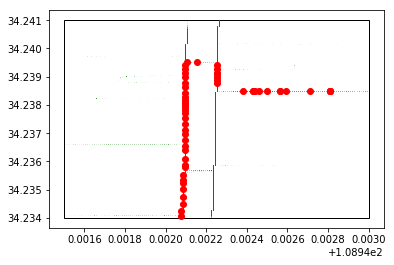

In [62]:
fig, ax = plt.subplots()
x=df_section.Longitude.tolist()
y=df_section.Latitude.tolist()
plt.plot(x,y,'g*',markersize=0.01)

currentAxis = plt.gca()
Lat_max,Long_max,Lat_min,Long_min
currentAxis.add_patch(Rectangle((Long_min, Lat_min), Long_max-Long_min, Lat_max-Lat_min,
                      fill=None))
x_sample=df_section_sample.Longitude.tolist()
y_sample=df_section_sample.Latitude.tolist()
plt.plot(x_sample,y_sample,'ro')
plt.show()